In [12]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

imports

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

from src.models.unet import UNet
from src.utils.data_loader import get_dataloader
from src.utils.config import VALID_DIR, VALID_ANNOTATIONS

GPU for the win

In [14]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


loading model and validation data

In [ ]:
model = UNet(in_channels=3, out_channels=14).to(device)
model.load_state_dict(torch.load("../unet_model.pth", map_location=device))
model.eval()

val_loader = get_dataloader(VALID_DIR, VALID_ANNOTATIONS, batch_size=4, shuffle=False)

## Evaluation function (IoU)

In [ ]:
def evaluate_model(model, dataloader, device, num_classes=14):
    model.eval()
    iou_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for cls in range(num_classes):
                pred_inds = (preds == cls)
                target_inds = (masks == cls)
                intersection = (pred_inds & target_inds).sum().item()
                union = (pred_inds | target_inds).sum().item()
                if union > 0:
                    iou_per_class[cls] += intersection / union
                    total_per_class[cls] += 1

    print("\nPer-Class IoU:")
    for cls in range(num_classes):
        if total_per_class[cls] > 0:
            avg_iou = iou_per_class[cls] / total_per_class[cls]
            print(f"Class {cls}: IoU = {avg_iou:.4f}")
        else:
            print(f"Class {cls}: No examples")

In [17]:
evaluate_model(model, val_loader, device)


Per-Class IoU:
Class 0: IoU = 0.9882
Class 1: IoU = 0.8252
Class 2: IoU = 0.1872
Class 3: IoU = 0.1583
Class 4: IoU = 0.1461
Class 5: IoU = 0.1094
Class 6: IoU = 0.1652
Class 7: IoU = 0.2002
Class 8: IoU = 0.1860
Class 9: IoU = 0.1757
Class 10: IoU = 0.2114
Class 11: IoU = 0.2603
Class 12: IoU = 0.2076
Class 13: IoU = 0.1355


## class distribution in validation set

In [ ]:
def count_classes(dataloader):
    print("\nClass Distribution (Validation Set):")
    class_counts = torch.zeros(14, dtype=torch.long)
    for _, masks in dataloader:
        for c in range(14):
            class_counts[c] += (masks == c).sum().item()
    for i, count in enumerate(class_counts):
        print(f"Class {i}: {count} pixels")

count_classes(val_loader)


Class Distribution (Validation Set):
Class 0: 2371581 pixels
Class 1: 88117 pixels
Class 2: 2810 pixels
Class 3: 2635 pixels
Class 4: 2679 pixels
Class 5: 2584 pixels
Class 6: 2739 pixels
Class 7: 2778 pixels
Class 8: 2621 pixels
Class 9: 2712 pixels
Class 10: 2212 pixels
Class 11: 2228 pixels
Class 12: 2068 pixels
Class 13: 2604 pixels


## Visualize predictions for a few samples


In [ ]:
def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            images = images.cpu()
            masks = masks.cpu()

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    return

                img = TF.to_pil_image(images[i])
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(img)
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i], cmap="tab20")
                plt.title("Ground Truth")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i], cmap="tab20")
                plt.title("Prediction")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                images_shown += 1

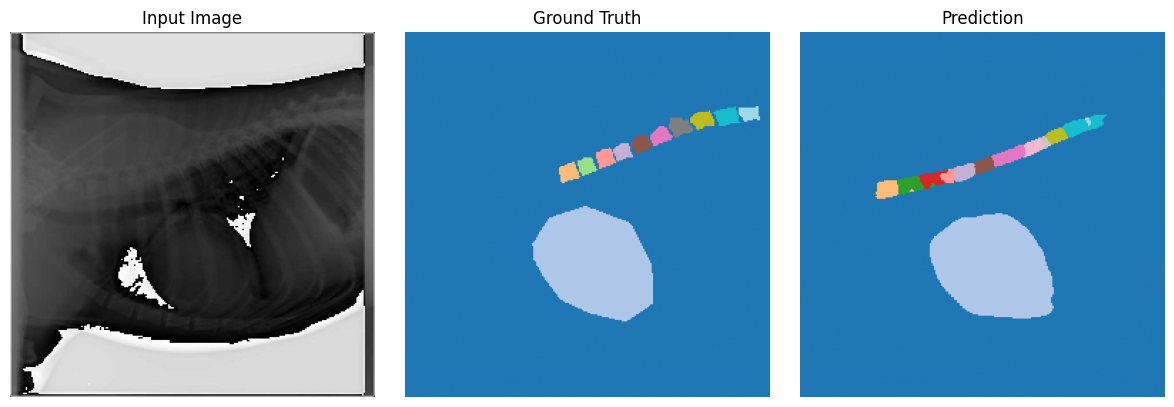

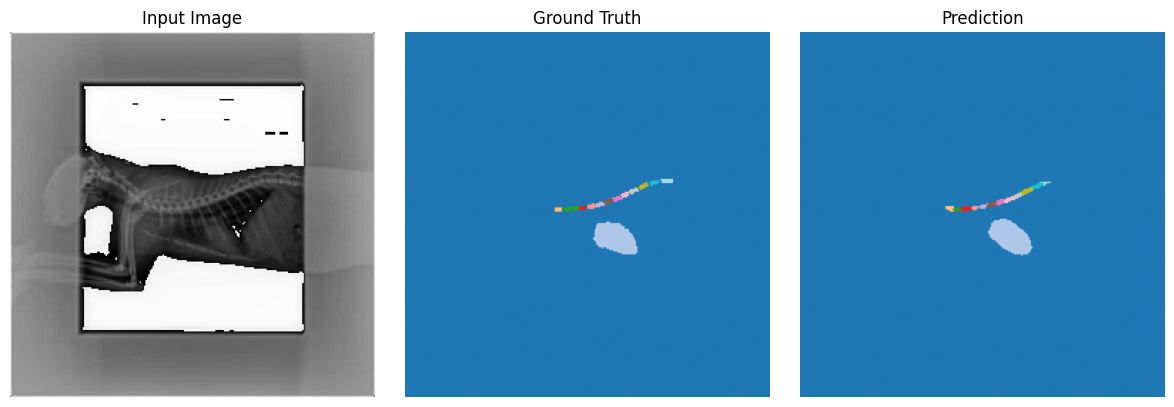

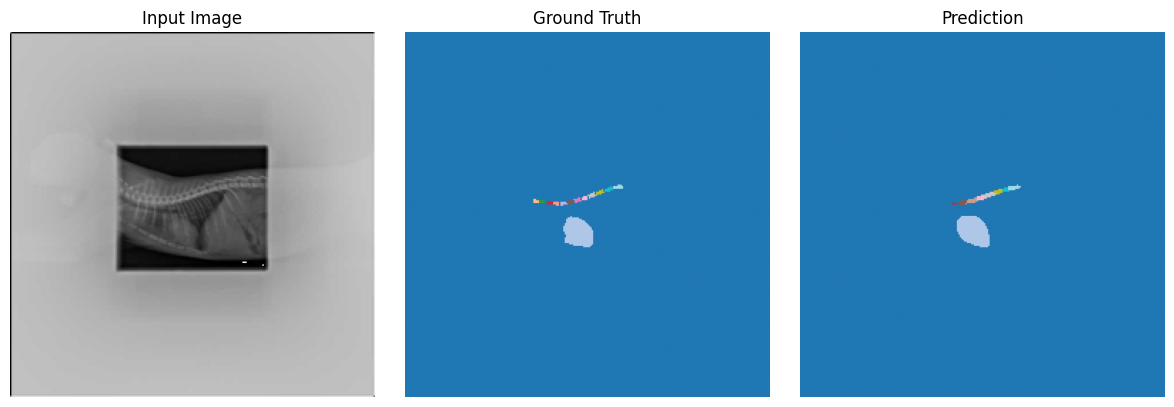

In [20]:
visualize_predictions(model, val_loader, device, num_samples=3)